# DAT341 Programming assignment 4: Implementing linear classifiers
## Yahui Wu(15hrs)


## Tianshuo Xiao(15hrs)

## Group 21

### Exercise

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from scipy.linalg import blas

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(f'Perceptron accuracy (Gothenburg): {accuracy_score(Y1, guesses1)}')


classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
#classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(f'Perceptron accuracy (Sydney): {accuracy_score(Y2, guesses2)}')

classifier3 = make_pipeline(DictVectorizer(), LinearSVC())
classifier3.fit(X2, Y2)
guesses3 = classifier3.predict(X2)
print(f'LinearSVC accuracy (Sydney): {accuracy_score(Y2, guesses2)}')

Perceptron accuracy (Gothenburg): 1.0
Perceptron accuracy (Sydney): 0.5
LinearSVC accuracy (Sydney): 0.5


In [19]:
import pandas as pd

dc = DictVectorizer()
x_1 = dc.fit_transform(X1)
df = pd.DataFrame(x_1.toarray(),dtype='int8')
df['label'] = Y1

x_2 = dc.fit_transform(X2)
df2 = pd.DataFrame(x_2.toarray(),dtype='int8')
df2['label'] = Y2


In [20]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)

X = pca.fit_transform(df.iloc[:,:-1].values)
X2 = pca.fit_transform(df2.iloc[:,:-1].values)

pos=pd.DataFrame()
pos2=pd.DataFrame()

pos['X'] =X[:, 0]
pos2['X2'] =X[:, 0]

pos['Y'] =X[:, 1]
pos2['Y2'] =X[:, 1]

pos['label'] = df['label']
pos2['label'] = df2['label']

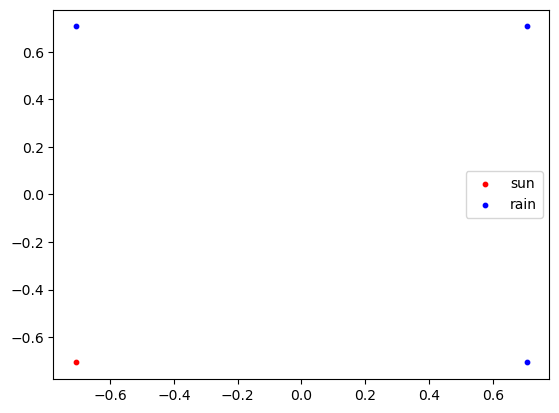

In [21]:
import matplotlib
import matplotlib.pyplot as plt
ax = pos.loc[pos['label']=='sun']

X_1 = list(ax['X'])
Y_1 = list(ax['Y'])
plt.scatter(X_1,Y_1,s=10,c='r',label='sun')
ax_0 = pos.loc[pos['label']=='rain']
X_0 = list(ax_0['X'])
Y_0 = list(ax_0['Y'])
plt.scatter(X_0,Y_0,s=10,c='b',label='rain')
plt.legend()
plt.show()

We can see from the figure that the dataset can linearly separable. Therefore, the perceptron learning algorithm will find a separated w in a limited number of steps.

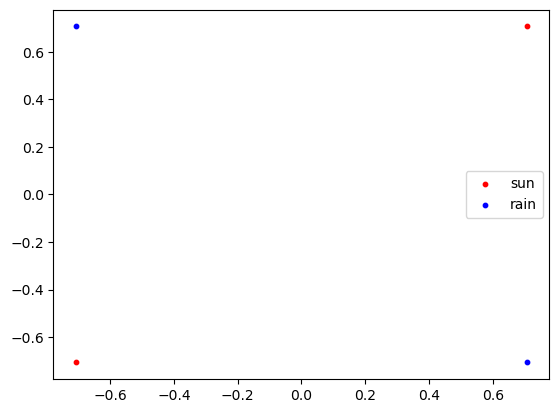

In [22]:
ax = pos2.loc[pos2['label']=='sun']

X_1 = list(ax['X2'])
Y_1 = list(ax['Y2'])
plt.scatter(X_1,Y_1,s=10,c='r',label='sun')
ax_0 = pos2.loc[pos2['label']=='rain']
X_0 = list(ax_0['X2'])
Y_0 = list(ax_0['Y2'])
plt.scatter(X_0,Y_0,s=10,c='b',label='rain')
plt.legend()
plt.show()

However, we can see from the figure that the data are not linearly separable, so there is not a w for classification.So this could be the reason for the misclassification.

### Introduction

In [10]:
"""This file shows a couple of implementations of the perceptron learning
algorithm. It is based on the code from Lecture 3, but using the slightly
more compact perceptron formulation that we saw in Lecture 6.

There are two versions: Perceptron, which uses normal NumPy vectors and
matrices, and SparsePerceptron, which uses sparse vectors and matrices.
The latter may be faster when we have high-dimensional feature representations
with a lot of zeros, such as when we are using a "bag of words" representation
of documents.
"""

import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


class Perceptron(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # Perceptron algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):

                # Compute the output score for this instance.
                score = x.dot(self.w)

                # If there was an error, update the weights.
                if y*score <= 0:
                    self.w += y*x


##### The following part is for the optional task.

### Sparse and dense vectors don't collaborate very well in NumPy/SciPy.
### Here are two utility functions that help us carry out some vector
### operations that we'll need.

def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)


class SparsePerceptron(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))

        for i in range(self.n_iter):
            for x, y in XY:

                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)

                # If there was an error, update the weights.
                if y*score <= 0:
                    # (This corresponds to self.w += y*x above.)
                    add_sparse_to_dense(x, self.w, y)

In [7]:
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#from aml_perceptron import Perceptron, SparsePerceptron

# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


if __name__ == '__main__':
    
    # Read all the documents.
    X, Y = read_data('all_sentiment_shuffled.txt')
    
    # Split into training and test parts.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)

    # Set up the preprocessing steps and the classifier.
    pipeline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),

        # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
        Perceptron()  
    )

    # Train the classifier.
    t0 = time.time()
    pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    print('Training time: {:.2f} sec.'.format(t1-t0))

    # Evaluate on the test set.
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 2.76 sec.
Accuracy: 0.7923.


### Implementing the SVC

We implement the Pegasos algorithm for training support vector classifiers by converting the pseudocode in Algorithm 1 in the clarification document, which uses the loss function of hinge loss.. As for regularization parameter C and the number of training steps, we used the recommendations from the assignment. We iterated 20 times through the training set and set C to 1/N, where N is the number of instances in X_train set. 

In [141]:
class LinearSVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C
        self.loss = []

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 1
        # Perceptron algorithm:
        for i in range(self.n_iter):
            #num_pairs = X.shape[0]
            #np.random.shuffle(training_pairs)
            
            
            for x, y in zip(X, Ye):
                #t is a “counter” that increases by one for each training instance we process
                t += 1
                # Setting the step length
                eta = 1/(self.C*t)

                # Compute the output score for this instance.
                score = x.dot(self.w)
                self.loss.append(max(0,1 - y*score))
                
                # If there was an error, update the weights by the hinge loss algorithm
                if y*score < 1:
                    self.w = (1-eta*self.C)*self.w + (eta*y)*x
                else:
                    self.w = (1-eta*self.C)*self.w
                
                
                
            avg_loss = sum(self.loss)/len(self.loss)
            print(f"Iteration {i}, average loss: {avg_loss}")

In [133]:
# Read all the documents.
X_svc, Y_svc = read_data('all_sentiment_shuffled.txt')
    
# Split into training and test parts.
Xtrain_svc, Xtest_svc, Ytrain_svc, Ytest_svc = train_test_split(X_svc, Y_svc, test_size=0.2,
                                                    random_state=0)


# Set up the preprocessing steps and the classifier.
pipeline_svc = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),

        # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
        LinearSVC(n_iter=20, C=1/len(Xtrain_svc))  
    )

# Train the classifier.
t0_svc = time.time()
pipeline_svc.fit(Xtrain_svc, Ytrain_svc)
t1_svc = time.time()
print('Training time: {:.2f} sec.'.format(t1_svc-t0_svc))

# Evaluate on the test set.
Yguess_svc = pipeline_svc.predict(Xtest_svc)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest_svc, Yguess_svc)))

Iteration 0, average loss: 1.0553166752607162
Iteration 1, average loss: 0.7135354237097752
Iteration 2, average loss: 0.5898683868406869
Iteration 3, average loss: 0.524517263262039
Iteration 4, average loss: 0.4836368264658004
Iteration 5, average loss: 0.45567450115529495
Iteration 6, average loss: 0.43511272834389886
Iteration 7, average loss: 0.4193510354118954
Iteration 8, average loss: 0.4068605736600731
Iteration 9, average loss: 0.3966681261190678
Iteration 10, average loss: 0.3881894931124227
Iteration 11, average loss: 0.38104028497834314
Iteration 12, average loss: 0.374918366630379
Iteration 13, average loss: 0.3696005213980102
Iteration 14, average loss: 0.3649399704179835
Iteration 15, average loss: 0.36083228996908523
Iteration 16, average loss: 0.3571614196511262
Iteration 17, average loss: 0.3538656161683418
Iteration 18, average loss: 0.35089299222846493
Iteration 19, average loss: 0.34819634207504246
Training time: 8.78 sec.
Accuracy: 0.8326.


### Logistic regression

We converted the loss function to a log loss, with other parameters unchanged.

In [123]:
class LogisticRegression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C
        self.loss = []

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 1
        # Perceptron algorithm:
        for i in range(self.n_iter):
            
            for x, y in zip(X, Ye):
                t += 1
                eta = 1/(self.C*t)

                # Compute the output score for this instance.
                score = x.dot(self.w)
                self.loss.append(np.log(1 + np.exp(-y * score)))
                
                # Update the weights by the log loss algorithm
                self.w = (1-eta*self.C)*self.w + eta*(y*x)/(1+np.exp(y*(self.w*x))) 
                
                
        
                                 
            avg_loss = sum(self.loss)/len(self.loss)
            print(f"Iteration {i}, average loss: {avg_loss}")
               

In [135]:
# Set up the preprocessing steps and the classifier.
pipeline_log = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),

        # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
        LogisticRegression(n_iter=20, C=1/len(Xtrain_svc))  
    )

# Train the classifier.
t0_log = time.time()
pipeline_log.fit(Xtrain_svc, Ytrain_svc)
t1_log = time.time()
print('Training time: {:.2f} sec.'.format(t1_log-t0_log))

# Evaluate on the test set.
Yguess_svc = pipeline_log.predict(Xtest_svc)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest_svc, Yguess_svc)))

Iteration 0, average loss: 0.9099698734725881
Iteration 1, average loss: 0.677264840612741
Iteration 2, average loss: 0.588659132737918
Iteration 3, average loss: 0.5406165093688889
Iteration 4, average loss: 0.5101184320693263
Iteration 5, average loss: 0.4889053967464099
Iteration 6, average loss: 0.473236189082661
Iteration 7, average loss: 0.46115674445479543
Iteration 8, average loss: 0.4515419326843679
Iteration 9, average loss: 0.44369603605243496
Iteration 10, average loss: 0.43716473306016723
Iteration 11, average loss: 0.4316382446568743
Iteration 12, average loss: 0.4268978047978385
Iteration 13, average loss: 0.422784358645719
Iteration 14, average loss: 0.41917939095346785
Iteration 15, average loss: 0.4159927199417426
Iteration 16, average loss: 0.4131544656795019
Iteration 17, average loss: 0.4106096131799976
Iteration 18, average loss: 0.40831423986130294
Iteration 19, average loss: 0.40623284036087826
Training time: 14.87 sec.
Accuracy: 0.8065.


By comparing the results, we found that the performance of SVC is slightly higher than that of logistic regression. The accuracy of SVC is 0.8326 and logistic regression is 0.8065, which is 0.03 higher. Moreover, the running time of logistic regression is longer than that of SVC, 8.78s and 14.87s, separately.

## Optional task: Printing the value of the objective function

We have implemented in the above program.

## Bonus tasks

### (a) Faster linear algebra operations

In [129]:
class FastLinearSVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C
        self.loss = []

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t = 1
        # Perceptron algorithm:
        for i in range(self.n_iter):
            #num_pairs = X.shape[0]
            #np.random.shuffle(training_pairs)
            
            
            for x, y in zip(X, Ye):
                t += 1
                eta = 1/(self.C*t)

                # Compute the output score for this instance.
                score = blas.ddot(x, self.w)
                #score = x.dot(self.w)
                self.loss.append(max(0,1 - y*score))
                
                # If there was an error, update the weights by the hinge loss algorithm
                if y*score < 1:
                    blas.daxpy(x, self.w, a = eta*y)
                    #self.w = blas.dscal((1 - blas.dscal(eta, self.C)), self.w) + blas.dscal(blas.dscal(eta, y), x)
                    #self.w = (1-eta*self.C)*self.w + (eta*y)*x
                else:
                    blas.dscal((1 - blas.dscal(eta, self.C)), self.w)
                    #self.w = (1-eta*self.C)*self.w
                
                
                
            avg_loss = sum(self.loss)/len(self.loss)
            print(f"Iteration {i}, average loss: {avg_loss}")

In [134]:
# Set up the preprocessing steps and the classifier.
pipeline_fsvc = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),

        # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
        FastLinearSVC(n_iter=20, C=1/len(Xtrain_svc))  
    )

# Train the classifier.
t0_fsvc = time.time()
pipeline_fsvc.fit(Xtrain_svc, Ytrain_svc)
t1_fsvc = time.time()
print('Training time: {:.2f} sec.'.format(t1_fsvc-t0_fsvc))

# Evaluate on the test set.
Yguess_fsvc = pipeline_fsvc.predict(Xtest_svc)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest_svc, Yguess_svc)))

Iteration 0, average loss: 1.136814290620031
Iteration 1, average loss: 0.7451121646326183
Iteration 2, average loss: 0.6047834514729149
Iteration 3, average loss: 0.5312201619033844
Iteration 4, average loss: 0.485437106190431
Iteration 5, average loss: 0.4542009231774633
Iteration 6, average loss: 0.4313507503206367
Iteration 7, average loss: 0.4138675711727284
Iteration 8, average loss: 0.400043071863277
Iteration 9, average loss: 0.38879098722244476
Iteration 10, average loss: 0.37947640483414175
Iteration 11, average loss: 0.3716506572774833
Iteration 12, average loss: 0.364949217477231
Iteration 13, average loss: 0.35913254324489224
Iteration 14, average loss: 0.35405525249946584
Iteration 15, average loss: 0.34956794242756417
Iteration 16, average loss: 0.3455755437710357
Iteration 17, average loss: 0.3419970180264606
Iteration 18, average loss: 0.3387729686268025
Iteration 19, average loss: 0.3358575205562579
Training time: 7.92 sec.
Accuracy: 0.8326.


By using BLAS, we speed up the model operations.The running time was reduced from 8.78s to 7.92s, which is around 10% more efficient.

###  (b)Using sparse vectors

#### Remove the SelectKBest

In [78]:
# Read all the documents.
X_svc, Y_svc = read_data('all_sentiment_shuffled.txt')
    
# Split into training and test parts.
Xtrain_svc, Xtest_svc, Ytrain_svc, Ytest_svc = train_test_split(X_svc, Y_svc, test_size=0.2,
                                                    random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline_svc = make_pipeline(
        TfidfVectorizer(),
        Normalizer(),

        # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
        LinearSVC(n_iter=10, C=1/len(Xtrain_svc))  
    )

# Train the classifier.
t0_svc = time.time()
pipeline_svc.fit(Xtrain_svc, Ytrain_svc)
t1_svc = time.time()
print('Training time: {:.2f} sec.'.format(t1_svc-t0_svc))

# Evaluate on the test set.
Yguess_svc = pipeline_svc.predict(Xtest_svc)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest_svc, Yguess_svc)))

Iteration 0, average loss: 0.8551040106180142
Iteration 1, average loss: 0.5695442812563352
Iteration 2, average loss: 0.45939591191577017
Iteration 3, average loss: 0.3986603357795712
Iteration 4, average loss: 0.3597977882010865
Iteration 5, average loss: 0.3326215911003023
Iteration 6, average loss: 0.31235966955151884
Iteration 7, average loss: 0.29662620575027293
Iteration 8, average loss: 0.2840651299339518
Iteration 9, average loss: 0.2737257159836662
Training time: 38.82 sec.
Accuracy: 0.8414.


#### Add the option ngram_range=(1,2)

In [79]:
# Read all the documents.
X_svc, Y_svc = read_data('all_sentiment_shuffled.txt')
    
# Split into training and test parts.
Xtrain_svc, Xtest_svc, Ytrain_svc, Ytest_svc = train_test_split(X_svc, Y_svc, test_size=0.2,
                                                    random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline_svc = make_pipeline(
        TfidfVectorizer(ngram_range=(1,2)),
        Normalizer(),

        # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
        LinearSVC(n_iter=10, C=1/len(Xtrain_svc))  
    )

# Train the classifier.
t0_svc = time.time()
pipeline_svc.fit(Xtrain_svc, Ytrain_svc)
t1_svc = time.time()
print('Training time: {:.2f} sec.'.format(t1_svc-t0_svc))

# Evaluate on the test set.
Yguess_svc = pipeline_svc.predict(Xtest_svc)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest_svc, Yguess_svc)))

Iteration 0, average loss: 0.5659392939180279
Iteration 1, average loss: 0.37366649618075776
Iteration 2, average loss: 0.29500332747658253
Iteration 3, average loss: 0.2500058832639561
Iteration 4, average loss: 0.2203034004202732
Iteration 5, average loss: 0.19916315148335478
Iteration 6, average loss: 0.18324313363366612
Iteration 7, average loss: 0.1707987859029892
Iteration 8, average loss: 0.1607331626639251
Iteration 9, average loss: 0.15241574560310717
Training time: 1272.28 sec.
Accuracy: 0.8695.


### SparsePerceptronSVC

In [136]:
class SparsePerceptronSVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C
        self.loss = []

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))
        t = 1
        for i in range(self.n_iter):
            for x, y in XY:
                t += 1
                eta = 1/(self.C*t)
                
                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = sparse_dense_dot(x, self.w)
                self.loss.append(max(0,1 - y*score))
                
                self.w = (1-eta*self.C)*self.w
                # If there was an error, update the weights by the hinge loss algorithm.
                if y*score < 1:
                    # (This corresponds to self.w += y*x above.)
                    add_sparse_to_dense(x, self.w, eta*y)
                    
            avg_loss = sum(self.loss)/len(self.loss)
            print(f"Iteration {i}, average loss: {avg_loss}")

In [137]:
# Read all the documents.
X_svc, Y_svc = read_data('all_sentiment_shuffled.txt')
    
# Split into training and test parts.
Xtrain_svc, Xtest_svc, Ytrain_svc, Ytest_svc = train_test_split(X_svc, Y_svc, test_size=0.2,
                                                    random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline_svc = make_pipeline(
        TfidfVectorizer(),
        Normalizer(),

        # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
        SparsePerceptronSVC(n_iter=20, C=1/len(Xtrain_svc))  
    )

# Train the classifier.
t0_svc = time.time()
pipeline_svc.fit(Xtrain_svc, Ytrain_svc)
t1_svc = time.time()
print('Training time: {:.2f} sec.'.format(t1_svc-t0_svc))

# Evaluate on the test set.
Yguess_svc = pipeline_svc.predict(Xtest_svc)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest_svc, Yguess_svc)))

Iteration 0, average loss: 0.7778718047201495
Iteration 1, average loss: 0.5309339681184192
Iteration 2, average loss: 0.43354922706315596
Iteration 3, average loss: 0.3792958536789474
Iteration 4, average loss: 0.3443494505213291
Iteration 5, average loss: 0.31975586007700996
Iteration 6, average loss: 0.30133292374728937
Iteration 7, average loss: 0.2869834302416344
Iteration 8, average loss: 0.2754734949388451
Iteration 9, average loss: 0.26600523259283493
Iteration 10, average loss: 0.2580592051796681
Iteration 11, average loss: 0.2512963208425407
Iteration 12, average loss: 0.24546792762713696
Iteration 13, average loss: 0.24036543141102026
Iteration 14, average loss: 0.2358741752312414
Iteration 15, average loss: 0.23188735923441167
Iteration 16, average loss: 0.22831057643680633
Iteration 17, average loss: 0.2250968453784514
Iteration 18, average loss: 0.22219118095053977
Iteration 19, average loss: 0.21954267218167553
Training time: 19.44 sec.
Accuracy: 0.8410.


We tested remove SelectKBest and add option ngram_range=(1,2) respectively, and found that their runtimes increased significantly. With SparsePerceptronSVC, the runtime decreases significantly.

### (c) Speeding up the scaling operation

In [139]:
class ScalingLinearSVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=20, C=1):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.C = C
        self.loss = []

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.

        Note that this will only work if X is a sparse matrix, such as the
        output of a scikit-learn vectorizer.
        """
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])
        a = 1.0
        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.
        XY = list(zip(X, Ye))
        t = 1
        for i in range(self.n_iter):
            
            for x, y in XY:
                t += 1
                eta = 1/(self.C*t)
                
                # Compute the output score for this instance.
                # (This corresponds to score = x.dot(self.w) above.)
                score = a*sparse_dense_dot(x, self.w)
                self.loss.append(max(0,1 - y*score))
                
                a = (1 - self.C*eta)*a
                if a == 0.:
                    a = 1e-9
                
                #self.w = (1-eta*self.C)*self.w
                # If there was an error, update the weights by the hinge loss algorithm
                if y*score < 1:
                    # (This corresponds to self.w += y*x above.)
                    add_sparse_to_dense(x, self.w, (eta*y)/a)
                    
            avg_loss = sum(self.loss)/len(self.loss)
            print(f"Iteration {i}, average loss: {avg_loss}")
        self.w *= a

In [140]:
# Read all the documents.
X_svc, Y_svc = read_data('all_sentiment_shuffled.txt')
    
# Split into training and test parts.
Xtrain_svc, Xtest_svc, Ytrain_svc, Ytest_svc = train_test_split(X_svc, Y_svc, test_size=0.2,
                                                    random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline_svc = make_pipeline(
        TfidfVectorizer(),
        Normalizer(),

        # NB that this is our LinearSVC, not sklearn.linear_model.LinearSVC
        ScalingLinearSVC(n_iter=20, C=1/len(Xtrain_svc))  
    )

# Train the classifier.
t0_svc = time.time()
pipeline_svc.fit(Xtrain_svc, Ytrain_svc)
t1_svc = time.time()
print('Training time: {:.2f} sec.'.format(t1_svc-t0_svc))

# Evaluate on the test set.
Yguess_svc = pipeline_svc.predict(Xtest_svc)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest_svc, Yguess_svc)))

Iteration 0, average loss: 0.7778718047201497
Iteration 1, average loss: 0.5309339681184203
Iteration 2, average loss: 0.43354922706315707
Iteration 3, average loss: 0.37929585367894847
Iteration 4, average loss: 0.34434945052133004
Iteration 5, average loss: 0.3197558600770106
Iteration 6, average loss: 0.3013329237472898
Iteration 7, average loss: 0.28698343024163464
Iteration 8, average loss: 0.27547349493884493
Iteration 9, average loss: 0.26600523259283465
Iteration 10, average loss: 0.25805920517966785
Iteration 11, average loss: 0.25129632084254067
Iteration 12, average loss: 0.2454679276271372
Iteration 13, average loss: 0.24036543141102076
Iteration 14, average loss: 0.23587417523124224
Iteration 15, average loss: 0.23188735923441287
Iteration 16, average loss: 0.22831057643680744
Iteration 17, average loss: 0.22509684537845276
Iteration 18, average loss: 0.22219118095054133
Iteration 19, average loss: 0.21954267218167697
Training time: 11.39 sec.
Accuracy: 0.8410.


By comparing results between SparseSVC and ScaledSVC, the model run time reduced by 8.05s, which means increase 41.4% in efficiency.